<a href="https://colab.research.google.com/github/GopalKrishna-India/ML_AI_for_TOF_Mapping/blob/main/BuildingTensorFlowModel21March24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the earth engine API, Google Cloud API and authenticate

In [1]:
!pip install earthengine-api
from google.colab import auth

auth.authenticate_user()

# Import the Earth Engine API and initialize it.
import ee

ee.Authenticate()
ee.Initialize(project='ee-geoinformers')

# Import the tensorflow library and import the training and testing data

In [7]:
import tensorflow as tf

#tf.enable_eager_execution()
print(tf.__version__)

trainFilePath = 'gs://treemapping_tofi/TreeMappingTest/Planet_training_points.tfrecord.gz'
testFilePath = 'gs://treemapping_tofi/TreeMappingTest/Planet_testing_points.tfrecord.gz'

print('Found training file.' if tf.io.gfile.exists(trainFilePath)
    else 'No training file found.')

# Create a dataset from the TFRecord file in Cloud Storage.
trainDataset = tf.data.TFRecordDataset(trainFilePath, compression_type='GZIP')
# Print the first record to check.
print(iter(trainDataset).next())


2.15.0
Found training file.
tf.Tensor(b'\n\xa1\x01\n\x0f\n\x03red\x12\x08\x12\x06\n\x04\xcc]\xcb=\n\x12\n\x06random\x12\x08\x12\x06\n\x04\xe8\x8c\x15?\n\x11\n\x05green\x12\x08\x12\x06\n\x04\x16\xfb\xcb=\n\x10\n\x04blue\x12\x08\x12\x06\n\x04\x89\xd2^=\n\x0f\n\x03nir\x12\x08\x12\x06\n\x04\x19\x04\x96>\n\x10\n\x04ndvi\x12\x08\x12\x06\n\x04m\xcd\xfc>\n\x11\n\x05class\x12\x08\x12\x06\n\x04\x00\x00\x80?\n\x1f\n\x0csystem:index\x12\x0f\n\r\n\x0b1_1_1_1_0_0', shape=(), dtype=string)


# Set the label and feature names

In [8]:
label = "class"

featureNames = list(['blue','green','red','nir',"ndvi"])
featureNames.append(label)

l = len(featureNames)
print(l)
featureNames = sorted(featureNames)
featureNames.append(label)

# List of fixed-length features, all of which are float32.
columns = [
  tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in featureNames
]

# Dictionary with names as keys, features as values.
featuresDict = dict(zip(featureNames, columns))

print(featuresDict)

6
{'blue': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'class': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'green': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'ndvi': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'nir': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'red': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None)}


# Read a serialized example into the structure defined by featuresDict.

In [9]:
def parse_tfrecord(example_proto):
  """The parsing function.

  Read a serialized example into the structure defined by featuresDict.

  Args:
    example_proto: a serialized Example.

  Returns:
    A tuple of the predictors dictionary and the label, cast to an `int32`.
  """
  parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
  labels = parsed_features.pop(label)
  return parsed_features, tf.cast(labels, tf.int32)

# Map the function over the dataset.
parsedDataset = trainDataset.map(parse_tfrecord, num_parallel_calls=5)

# Print the first parsed record to check.
print(iter(parsedDataset).next())

({'blue': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0544], dtype=float32)>, 'green': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0996], dtype=float32)>, 'ndvi': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.49375477], dtype=float32)>, 'nir': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.293], dtype=float32)>, 'red': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0993], dtype=float32)>}, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>)


# Build the model

Epoch 1/100
10/10 [==============================] - 5s 59ms/step - loss: 0.9593 - accuracy: 0.6200
Epoch 2/100
10/10 [==============================] - 3s 363ms/step - loss: 0.5739 - accuracy: 0.7358
Epoch 3/100
10/10 [==============================] - 1s 59ms/step - loss: 0.3498 - accuracy: 0.7255
Epoch 4/100
10/10 [==============================] - 3s 60ms/step - loss: 0.2961 - accuracy: 0.8010
Epoch 5/100
10/10 [==============================] - 2s 174ms/step - loss: 0.3853 - accuracy: 0.7865
Epoch 6/100
10/10 [==============================] - 1s 58ms/step - loss: 0.6956 - accuracy: 0.6531
Epoch 7/100
10/10 [==============================] - 1s 60ms/step - loss: 2.0237 - accuracy: 0.6380
Epoch 8/100
10/10 [==============================] - 1s 117ms/step - loss: 4.2020 - accuracy: 0.5897
Epoch 9/100
10/10 [==============================] - 1s 58ms/step - loss: 5.3276 - accuracy: 0.5420
Epoch 10/100
10/10 [==============================] - 1s 62ms/step - loss: 9.3246 - accuracy: 0.5

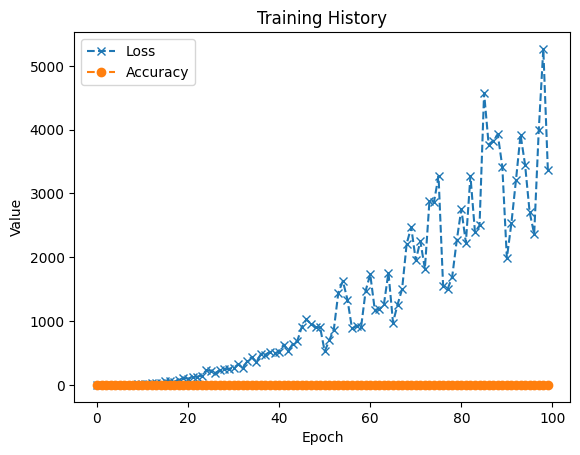

In [21]:
# Commented out IPython magic to ensure Python compatibility.
from tensorflow import keras
import matplotlib.pyplot as plt

# How many classes there are in the model.
nClasses = 5

# Add features .
inputDataset = parsedDataset #.map(addFeatures)

# Keras requires inputs as a tuple. Note that the inputs must be in the
# right shape. Also note that to use the categorical_crossentropy loss,
# the label needs to be turned into a one-hot vector.

def toTuple(data_dict, label):
  #return tf.transpose(list(dict.values())), tf.one_hot(indices=label, depth=nClasses)
    return (tf.expand_dims(tf.transpose(list(data_dict.values())), 1),
            tf.expand_dims(tf.one_hot(indices=label, depth=nClasses), 1))


# Repeat the input dataset as many times as necessary in batches.
inputDataset = inputDataset.map(toTuple).shuffle(3000).batch(300).repeat()

# Define the layers in the model.
model = tf.keras.models.Sequential([
tf.keras.layers.Input((None, None, l-1,)),
tf.keras.layers.Conv2D(512, (1, 1), activation=tf.nn.relu),
tf.keras.layers.Dropout(0.15),
tf.keras.layers.Conv2D(256, (1, 1), activation=tf.nn.relu),
tf.keras.layers.Dropout(0.15),
tf.keras.layers.Conv2D(nClasses, (1, 1), activation=tf.nn.softmax)
])

# Compile the model with the specified loss function.
# Compile the model with the specified loss function.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Fit the model to the training data.
# Don't forget to specify `steps_per_epoch` when calling `fit` on a dataset.
training = model.fit(x=inputDataset, epochs=100,steps_per_epoch=10)

# Plot the training history
plt.plot(training.history['loss'], 'x--', label='Loss')
plt.plot(training.history['accuracy'], 'o--', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training History')
plt.legend()
plt.show()

# Do the data validation using the test data

In [ ]:
testDataset = (
  tf.data.TFRecordDataset(testFilePath, compression_type='GZIP')
    .map(parse_tfrecord, num_parallel_calls=5)
    .map(toTuple)
    .batch(1)
)

model.evaluate(testDataset)

    151/Unknown - 2s 10ms/step - loss: 0.4941 - acc: 0.8146

[0.49410629941916157, 0.81456953]

# Save your model in your cloud bucket

In [ ]:
outputBucket = "yourbucket/Hanoi/"
MODEL_DIR = 'gs://' + outputBucket + '/model'
tf.contrib.saved_model.save_keras_model(model, MODEL_DIR)

# Make your model readable for the earthEngine

In [ ]:
from tensorflow.python.tools import saved_model_utils

meta_graph_def = saved_model_utils.get_meta_graph_def(MODEL_DIR, 'serve')
inputs = meta_graph_def.signature_def['serving_default'].inputs
outputs = meta_graph_def.signature_def['serving_default'].outputs

# Just get the first thing(s) from the serving signature def.  i.e. this
# model only has a single input and a single output.
input_name = None
for k,v in inputs.items():
  input_name = v.name
  break

output_name = None
for k,v in outputs.items():
  output_name = v.name
  break

# Make a dictionary that maps Earth Engine outputs and inputs to
# AI Platform inputs and outputs, respectively.
import json
input_dict = "'" + json.dumps({input_name: "array"}) + "'"
output_dict = "'" + json.dumps({output_name: label}) + "'"

print(input_dict)
print(output_dict)

# Put the EEified model next to the trained model directory.
EEIFIED_DIR = 'gs://' + outputBucket + '/eeified'
PROJECT = 'servir-rlcms'

#print(EEIFIED_DIR)
# You need to set the project before using the model prepare command.
!earthengine set_project {PROJECT}
!earthengine model prepare --source_dir {MODEL_DIR} --dest_dir {EEIFIED_DIR} --input {input_dict} --output {output_dict}

# Push your model to the AI platform

In [ ]:
import time
MODEL_NAME = 'Hanoi'
VERSION_NAME = 'v' + str(int(time.time()))
print('Creating version: ' + VERSION_NAME)

#!gcloud ai-platform models create {MODEL_NAME} --project {PROJECT}
!gcloud ai-platform versions create {VERSION_NAME} \
  --project {PROJECT} \
  --model {MODEL_NAME} \
  --origin {EEIFIED_DIR} \
  --runtime-version=1.14 \
  --framework "TENSORFLOW" \
  --python-version=3.5

Creating version: v1571915575
